## Importation des bliblothèques

In [77]:
import sqlite3
import pandas as pd

## Connection à la base de données

In [78]:
connect = sqlite3.connect("../../Databases/raw-database.db")
cursor = connect.cursor()

## Importation des données freeze frames

In [79]:
req = cursor.execute(f"SELECT frame, event_id, match_id_SKC, period FROM freeze_frames")
res = req.fetchall()
desc = req.description
freeze_frames = pd.DataFrame(res)
freeze_frames.columns = [i[0] for i in desc]

In [80]:
# Aperçu des données
freeze_frames.head(3)

,frame,event_id,match_id_SKC,period
0,4820,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1020089,1.0
1,4834,28239a7e-4d65-4618-99f3-2763088e5e92,1020089,1.0
2,4854,3ea6ecd9-bc39-4ce5-9b47-1eda239f2705,1020089,1.0


## Importation des données events

In [81]:
# On récupère les event_id SB pour pouvoir importer uniquement ceux qui nous intéressent depuis la table events
event_id_freeze_frames = freeze_frames.event_id.unique().tolist()

In [82]:
req = cursor.execute(f"SELECT event_id, pass_cross, pass_type, team_id_SB FROM events WHERE event_id IN ({', '.join('?' * len(event_id_freeze_frames))})",
                     event_id_freeze_frames)
res = req.fetchall()
desc = req.description
events = pd.DataFrame(res)
events.columns = [i[0] for i in desc]

In [83]:
# Aperçu des données
events.head(3)

,event_id,pass_cross,pass_type,team_id_SB
0,2e85ad3e-59c4-479a-a478-4c98174f686b,NaN,None,156
1,872df8f3-a750-4b61-8890-61a35e96b4a4,1.0,None,147
2,0f842e18-1363-4af3-8faa-6c9cce55b118,NaN,None,147


## Jointure des events avec les freeze frames

In [84]:
freeze_frames_events = pd.merge(freeze_frames, events, on = "event_id")
freeze_frames_events.sort_values(by = ["match_id_SKC", "frame"], inplace = True)

In [85]:
# Aperçu des données
freeze_frames_events.head(3)

,frame,event_id,match_id_SKC,period,pass_cross,pass_type,team_id_SB
0,4820,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1020089,1.0,NaN,None,143
1,4834,28239a7e-4d65-4618-99f3-2763088e5e92,1020089,1.0,1.0,None,143
2,4854,3ea6ecd9-bc39-4ce5-9b47-1eda239f2705,1020089,1.0,NaN,None,143


La colonne "team_id_SB" contient donc l'id des équipes liées aux events.  
Étant donné que nous travaillons avec des données Skill Corner, il est plus logique de travailler avec les id SK des équipes.  
Nous allons donc faire matcher ces id SB avec les id SK grâce à la table de matching des équipes.

In [86]:
# Importation des données de matching entre les id Skill Corner et Stats Bomb des équipes
req = cursor.execute(f"SELECT * FROM matching_teams")
res = req.fetchall()
desc = req.description
matching_teams = pd.DataFrame(res)
matching_teams.columns = [i[0] for i in desc]

In [87]:
# Aperçu des données
matching_teams.head(2)

,team_id_SB,team_id_SKC
0,168,85
1,144,66


In [88]:
freeze_frames_events = pd.merge(freeze_frames_events, matching_teams, on = "team_id_SB")

In [89]:
freeze_frames_events.head(2)

,frame,event_id,match_id_SKC,period,pass_cross,pass_type,team_id_SB,team_id_SKC
0,4820,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1020089,1.0,NaN,None,143,78
1,4834,28239a7e-4d65-4618-99f3-2763088e5e92,1020089,1.0,1.0,None,143,78


In [90]:
# Nous pouvons supprimer la colonne "team_id_SB" qui ne nous est plus utile à présent
freeze_frames_events.drop("team_id_SB", axis = 1, inplace = True)

## Analyse des centres

In [91]:
# Création d'un dataframe ne comprenant que les centres du dataframe initial
centres = freeze_frames_events[freeze_frames_events.pass_cross == 1]

In [92]:
# On regarde si il y'a des centres qui sont présents plusieurs fois
# On utilise l'identifiant "event_id" qui permet d'identifier, de manière unique, chaque event SB
centres.event_id.is_unique

True

On souhaite maintenant identifier chaque centre et chaque évènement précédant un centre par un centre_id.  
Chaque couple (event précédant le centre, centre) sera alors identifié par un unique centre_id.  

De plus, on part du principe qu'on dispose bien de chaque évènement précédant les centres.  
En effet, étant donné que nous ne nous sommes pas chargé de fusionner les évènements précédant et suivant les centres aux évènements correspondant aux centres, nous ne pouvons pas gérer ces erreurs.

Pour gérer les cas ou l'évènement suivant un centre (centre1) est également un centre (centre2), nous partons du principe que ces centres ne sont pas dupliqués mais plutôt que ces centres se suivent en terme d'event.  
En effet, nous n'aurons pas 2 couples (event avant centre1, centre1, centre2) et (centre1, centre2, event après centre2) mais plutot un couple (event avant centre1, centre1, centre2, event après centre2)

In [93]:
# Nous partons de ce principe car nous n'avons pas de valeur dupliquée pour la colonne event_id :
print(freeze_frames_events.event_id.is_unique)

True


Enfin, il est nécessaire des supprimer les events correspondants à des coups de pied arretés car ce n'est pas cohérent d'étudier les évènements précédant des CPA.

In [94]:
# Liste des CPA définis par Stats Bomb
CPA = ["Corner", "Free Kick", "Goal Kick", "Kick Off"]

# Supression des CPA des centres
centres = centres[~centres.pass_type.isin(CPA)]

In [95]:
centres.head(2)

,frame,event_id,match_id_SKC,period,pass_cross,pass_type,team_id_SKC
1,4834,28239a7e-4d65-4618-99f3-2763088e5e92,1020089,1.0,1.0,None,78
4,5755,d3b91062-3398-4235-8bbc-3571d2fd2d9c,1020089,1.0,1.0,None,70


In [96]:
# La colonne team_id_SKC contient donc les id SKC des équipes qui ont effectué les centres
# Nous allons renommer cette colonne "team_centre_id_SKC" pour bien indiquer qu'elle correspond aux équipes ayant effectué les centres
centres.rename({"team_id_SKC" : "team_centre_id_SKC"}, axis = 1, inplace = True)

print("Nombre de centres pour lesquels nous ne connaissons pas l'équipe qui les a effectués :", len(centres[centres.team_centre_id_SKC.isna()]))

Nombre de centres pour lesquels nous ne connaissons pas l'équipe qui les a effectués : 0


In [97]:
# identification des évènements précédant les centres
index_events_avant_centre = centres.index - 1

In [98]:
# Création d'un dataframe ne comprenant que les actions précédents les centres
events_avant_centre = freeze_frames_events.loc[index_events_avant_centre]

In [99]:
# On regarde si il y'a des évènements précédents des centres qui correspondent à des centres
events_avant_centre[events_avant_centre.pass_cross == 1]

,frame,event_id,match_id_SKC,period,pass_cross,pass_type,team_id_SKC


In [100]:
# Autre moyen de vérifier
print(len(index_events_avant_centre.intersection(centres.index)))

0


Il n'y en a pas

In [101]:
# Attribution des centre_id à chaque events précédant les centres et à chaque centre
events_avant_centre["centre_id"] = range(len(events_avant_centre))
centres["centre_id"] = range(len(events_avant_centre))

In [102]:
# On attribue aux events précédant les centres l'équipe qui a effectué le centre (suivant ces events)
# En effet, il est possible que l'équipe en possession du ballon lors de l'évènement précédant un centre ne soit pas la même
# que celle qui a effectué le centre en question
# De ce fait, il est nécessaire de remplacer l'équipe actuellement attribuée aux events précédant les centres par les équipes ayant effectué 
# les centres
events_avant_centre.drop("team_id_SKC", axis = 1, inplace = True)
events_avant_centre = pd.merge(events_avant_centre, centres[["team_centre_id_SKC", "centre_id"]], on = "centre_id")

In [103]:
# Aperçu des données
events_avant_centre.head(2)

,frame,event_id,match_id_SKC,period,pass_cross,pass_type,centre_id,team_centre_id_SKC
0,4820,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1020089,1.0,NaN,None,0,78
1,5752,c1a7a598-9690-4a32-a733-b7b3b585df83,1020089,1.0,NaN,None,1,70


Nous avons terminé cette première étape qui nous a permis d'analyser et extraire les centres ainsi que les évènements les précédant.  
Nous obtenons finalement un dataframe composé de l'ensemble des events précédant les centres dont nous disposons.  
Ce dataframe contient des informations cruciales telles que la période durant laquelle est survenu l'action, l'identifiant de la frame (le couple ["frame", "match_id_SKC"]), l'identifiant de l'event SB ("event_id") ou encore l'identifiant du centre que nous avons créé, dans le but de pouvoir retrouver le centre auquel correspond l'event précédant un centre.

Nous allons maintenant passer à l'analyse de la position des joueurs au moment de l'event précédant le centre.  
Pour cela, nous allons utiliser les données de tracking que nous avions au préalable importées dans la BDD SQLite grâce à nos programmes d'importation.

# Importation des données de tracking

In [104]:
req = cursor.execute(f"SELECT trackable_object, x, y, event_id FROM tracking_data")
res = req.fetchall()
desc = req.description
tracking_data = pd.DataFrame(res)
tracking_data.columns = [i[0] for i in desc]

In [105]:
# Aperçu des données
tracking_data.head(2)

,trackable_object,x,y,event_id
0,12235.0,45.43,-0.97,54cbad0c-1f05-4708-9b7f-2cadeae0636b
1,12327.0,32.26,-2.78,54cbad0c-1f05-4708-9b7f-2cadeae0636b


Nous allons maintenant fusionner le dataframe des events précédant les centres avec le dataframe des données de tracking.  
En effet, on souhaite étudier seulement les positions des joueurs sur les events précédant des centres, or le dataframe tracking_data actuel contient les données de toutes les frames disponibles.  
Pour effectuer ce merge, nous allons joindre les deux dataframes par rapport à la colonne "event_id" qui identifie de manière unique chaque event SB, et nous partons du principe qu'il n'y a aucun event dupliqué dans les données.  
Pour cette jointure, nous n'utilisons pas le couple ["match_id_SKC", "frame"], qui identifie de manière unique chaque frame, car dans le cas ou Stats Bomb recenserait 2 events correspondant à la même frame SK (ie. qui se déroulent au même instant), alors la même frame serait présente 2 fois dans les données.

In [106]:
td_avant_centre = pd.merge(events_avant_centre[["match_id_SKC", "event_id", "period", "centre_id", "team_centre_id_SKC"]], tracking_data,
                           on = "event_id")
# td_avant_centre correspond à "tracking data des events avant les centres"

In [107]:
# Aperçu des données
td_avant_centre.head(2)

,match_id_SKC,event_id,period,centre_id,team_centre_id_SKC,trackable_object,x,y
0,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12235.0,45.43,-0.97
1,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12327.0,32.26,-2.78


Nous allons maintenant regarder s'il y'a des frames (des events précédant les centres) pour lesquelles nous n'avons pas de tracking data

In [108]:
print("Nombre de centres pour lesquels nous n'avons pas d'information sur la frame de l'event précédent le centre dans les données de tracking :",
      len(events_avant_centre[~events_avant_centre.centre_id.isin(td_avant_centre.centre_id)]))
print("Nombre total de frames correspondant à des events précédant un centre :", len(events_avant_centre))

Nombre de centres pour lesquels nous n'avons pas d'information sur la frame de l'event précédent le centre dans les données de tracking : 40
Nombre total de frames correspondant à des events précédant un centre : 6181


On remarque qu'il y'a seulement 38 des 6181 frames pour lesquelles nous n'avons pas de données de tracking, ce qui reste raisonnablement faible.

---

Rappel : nous souhaitons étudier le nombre d'adversaires entre le ballon et le but pendant l'évènement précédant le centre.  
Or, pour l'instant, nous ne savons pas à quelles équipes appartiennent les joueurs (qui sont identifiés par la colonne "trackable_object").  
Dans la prochaine section, nous allons donc faire matcher les joueurs avec l'id SK de leur équipe

# Matching des joueurs avec leur équipe (pour chaque match)

Nous allons faire matcher, pour chaque match, l'ensemble des id Stats Bomb des joueurs présents sur la feuille de match avec l'id Skill Corner de leur équipe respectif.  
Il est important de bien s'intéresser aux id des joueurs pour chaque match et non sur une saison.  
En effet, dans le cas ou un joueur serait transféré d'une équipe à une autre au cours d'une saison, il aurait alors 2 valeurs (dans le cas ou on ferait matcher le joueur avec son équipe sur la saison)

Pour obtenir ce matching, nous allons utiliser les données lineup de Stats Bomb qui nous fournissent, pour chaque match, la liste des id des joueurs sur la feuille de match ainsi que les id SB des équipes auxquelles ils appartiennent.  
De plus, nous utiliserons les tables de matching pour les id SB et SK des matches, des équipes et des joueurs.

Rappel : nous avons déjà importé la table de matching des id SK et SB des équipes

In [109]:
# Importation des données de matching entre les id Skill Corner et Stats Bomb des matches
req = cursor.execute(f"SELECT * FROM matching_matches")
res = req.fetchall()
desc = req.description
matching_matches = pd.DataFrame(res)
matching_matches.columns = [i[0] for i in desc]

In [110]:
# Aperçu des données
matching_matches.head(2)

,match_id_SB,match_id_SKC
0,3894366.0,1547880
1,3894367.0,1547881


In [111]:
# Importation des données lineup de Stats Bomb.
req = cursor.execute(f"SELECT player_id_SB, team_id_SB, match_id_SB FROM lineups")
res = req.fetchall()
desc = req.description
lineups = pd.DataFrame(res)
lineups.columns = [i[0] for i in desc]

In [112]:
# Aperçu des données
lineups.head(2)

,player_id_SB,team_id_SB,match_id_SB
0,2941,147,3894037
1,3044,147,3894037


In [113]:
# Importation des données de matching des id SK et SB des joueurs.
# De plus, nous allons aussi importer la colonne "trackable_object" qui est utilisée pour identifier les joueurs dans les données de tracking
req = cursor.execute(f"SELECT trackable_object, player_id_SB, player_id_SKC FROM matching_players")
res = req.fetchall()
desc = req.description
matching_players = pd.DataFrame(res)
matching_players.columns = [i[0] for i in desc]

In [114]:
# Aperçu des données
matching_players.head(2)

,trackable_object,player_id_SB,player_id_SKC
0,820104,307251.0,818541
1,39010,66886.0,37889


Nous allons maintenant faire matcher les id SB des joueurs, des équipes et des matches avec leur id SK respectif

In [115]:
# Matching des id des matches
merge_match_id = pd.merge(lineups, matching_matches, on = "match_id_SB")

In [116]:
# Aperçu des données
merge_match_id.head(2)

,player_id_SB,team_id_SB,match_id_SB,match_id_SKC
0,2941,147,3894037,1020753
1,3044,147,3894037,1020753


In [117]:
# Matching des id des joueurs
merge_player_id = pd.merge(merge_match_id, matching_players, on = "player_id_SB")

In [118]:
# Aperçu des données
merge_player_id.head(2)

,player_id_SB,team_id_SB,match_id_SB,match_id_SKC,trackable_object,player_id_SKC
0,2941,147,3894037,1020753,11308,11274
1,3044,147,3894037,1020753,1743,1733


In [119]:
# Enfin, il ne nous reste plus qu'à faire matcher les id des équipes
matching_player_team = pd.merge(merge_player_id, matching_teams, on = "team_id_SB")

In [120]:
# Aperçu des données
matching_player_team.head(2)

,player_id_SB,team_id_SB,match_id_SB,match_id_SKC,trackable_object,player_id_SKC,team_id_SKC
0,2941,147,3894037,1020753,11308,11274,80
1,3044,147,3894037,1020753,1743,1733,80


Nous ne souhaitons conserver que les informations qui nous serons utiles pour le matching avec les données de tracking, c'est à dire les colonnes  "match_id_SKC", "trackable_object" et "team_id_SKC".

In [121]:
matching_player_team = matching_player_team[["match_id_SKC", "trackable_object", "team_id_SKC"]]

In [122]:
# De plus, nous renommons la colonne "team_id_SKC" par "team_player_id_SKC" afin d'éviter toute confusion
matching_player_team.rename({"team_id_SKC" : "team_player_id_SKC"}, axis = 1, inplace = True)

---

Nous avons maintenant terminé de créer les données de matching nécessaire, nous allons donc les appliquer aux données de tracking.

In [123]:
# Rappel données de tracking
td_avant_centre.head(2)

,match_id_SKC,event_id,period,centre_id,team_centre_id_SKC,trackable_object,x,y
0,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12235.0,45.43,-0.97
1,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12327.0,32.26,-2.78


Nous allons faire matcher les joueurs avec leur équipe

In [124]:
# Nous rajoutons le paramètre : how = "left" afin d'effectuer un "left join" SQL.
# En effet, les données de tracking contiennent aussi des informations sur le ballon, qui ne possède pas d'équipe.
# En effectuant un inner join (qui est la jointure effectuée par défaut par la commande merge de Pandas), cela ne gardera pas les données de
# tracking du ballon car il n'est pas référencé dans les données de matching_player_team
tracking_data = pd.merge(td_avant_centre, matching_player_team, on = ["match_id_SKC", "trackable_object"], how = "left")
# Nous nommons ce dataframe tracking_data car c'est le dataframe final

In [125]:
# Aperçu des données
tracking_data.head(2)

,match_id_SKC,event_id,period,centre_id,team_centre_id_SKC,trackable_object,x,y,team_player_id_SKC
0,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12235.0,45.43,-0.97,70.0
1,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12327.0,32.26,-2.78,70.0


In [126]:
# Colonnes pour lesquelles on a des données manquantes
tracking_data.isna().any()

match_id_SKC          False
event_id              False
period                False
centre_id             False
team_centre_id_SKC    False
trackable_object      False
x                     False
y                     False
team_player_id_SKC     True
dtype: bool

On peut voir qu'il y'a des joueurs pour lesquels nous ne connaissons pas l'id SK de leur équipe (pour un ou plusieurs matchs).  

In [127]:
# On regarde les joueurs (trackable_object) dont on ne connait pas leur équipe sur un match
tracking_data[tracking_data.team_player_id_SKC.isna()].trackable_object.drop_duplicates()

22            55.0
1965       32283.0
44099     797972.0
83337     812065.0
90784      93910.0
112917    818917.0
139112    828435.0
Name: trackable_object, dtype: float64

On remarque qu'il y'a le trackable_object 55, qui correspond au ballon, c'est donc normal qu'on ne connaisse pas son équipe

In [128]:
# On regarde le nombre de tracks liées à des joueurs dont on ne connait pas l'id SK de leur équipe pour le match en question
nb_tracks_team_na = len(tracking_data[(tracking_data.team_player_id_SKC.isna()) & (tracking_data.trackable_object != 55)])
print("Nombre de tracks liées à des joueurs dont on ne connait pas l'id SK de leur équipe pour le match en question :", nb_tracks_team_na)
print("Ratio par rapport au nombre total de tracks disponibles :", round(nb_tracks_team_na*100/len(tracking_data), 2), "%")

Nombre de tracks liées à des joueurs dont on ne connait pas l'id SK de leur équipe pour le match en question : 490
Ratio par rapport au nombre total de tracks disponibles : 0.35 %


Il n'y a que 550 tracks qui correspondent à ce cas, ce qui est minoritaire par rapport au nombre de tracks disponibles

In [129]:
# On décide donc de retirer ces tracks du dataframe
# Cependant, il faut bien faire attention à ne pas retirer les tracks du ballon (trackable object 55)
tracking_data = tracking_data[(~tracking_data.team_player_id_SKC.isna()) | (tracking_data.trackable_object == 55)]

---
Nous pouvons maintenant passer à la dernière partie qui concerne à étudier la position des joueurs adverses (à l'équipe qui a centré) lors de l'évènement précédant le centre.  

# Étude de la position des adversaires lors de l'action précédant le centre

Nous allons regarder pour chaque centre, le nombre d'adversaires entre le ballon et le but.  
Pour cela, nous allons entre autre nous servir de la variable centre_id qui permet d'identifier de manière unique chaque centre disponible.  
Nous souhaitons donc étudier uniquement les tracks liées au joueur pour lesquels l'id SK de leur équipe est différent de l'id SK de l'équipe ayant effectué le centre

In [130]:
# Nous récupérons toutes les tracks liées au ballon
positions_ballon = tracking_data[tracking_data.trackable_object == 55]

In [131]:
# Nous gardons seulement les adversaires de l'équipe qui a centré
# Il faut bien penser à ne pas prendre les tracks liées au ballon 
tracking_data_adv = tracking_data[(tracking_data.team_centre_id_SKC != tracking_data.team_player_id_SKC) & (tracking_data.trackable_object != 55)]

In [132]:
# On regarde s'il y a des tracks liées au ballon pour lesquels on a aucun track de joueur adverse (par rapport au centre_id)
positions_ballon[~positions_ballon.centre_id.isin(tracking_data_adv.centre_id)]

,match_id_SKC,event_id,period,centre_id,team_centre_id_SKC,trackable_object,x,y,team_player_id_SKC


In [133]:
# Et inversement, s'il y a des tracks de joueurs adverses pour lesquels on n'a pas de track de ballon associé
tracking_data_adv[~tracking_data_adv.centre_id.isin(positions_ballon.centre_id)]

,match_id_SKC,event_id,period,centre_id,team_centre_id_SKC,trackable_object,x,y,team_player_id_SKC


In [134]:
# Pour pouvoir facilement détecter la position des joueurs adverses par rapport au ballon, nous allons ajouter à chaque ligne la position du ballon
# lors de l'event précédant un centre auquel la ligne fait référence.
# Pour ce faire, nous allons effectuer une jointure au niveau du centre_id
tracking_data_adv = pd.merge(tracking_data_adv, positions_ballon[["centre_id", "x", "y"]], on = "centre_id", suffixes = (None, "_ballon"))

In [135]:
# Aperçu des données
tracking_data_adv.head(2)

,match_id_SKC,event_id,period,centre_id,team_centre_id_SKC,trackable_object,x,y,team_player_id_SKC,x_ballon,y_ballon
0,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12235.0,45.43,-0.97,70.0,32.96,-28.64
1,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12327.0,32.26,-2.78,70.0,32.96,-28.64


---
Avant de passer à la partie finale qui nous permettra de connaitre le nombre d'adversaires entre le ballon et le but sur les actions précédant des centres, il est nécessaire de régler un problème lié aux coordonnées Skill Corner.  
En effet, pour savoir quelle est la partie du terrain correspondant à la zone entre le ballon et le but, il est nécessaire de savoir vers quel coté attaque l'équipe qui a centré, càd savoir de quel coté défendent les joueurs adverses.  
Or, nous n'avons pas cette information actuellement, cependant nous savons grâce aux données "SKC_cote_attaque_home_team", pour chaque match id SK, vers quels cotés l'équipe à domicile attaque en 1ère et 2nd période.  
Grâce à différentes jointures/matching, nous allons pouvoir retrouver cette information qu'il nous manque.

### Standardisation des coordonnées Skill Corner

Nous allons dans un premier temps importer les données "SKC_cote_attaque_home_team"

In [136]:
req = cursor.execute(f"SELECT * FROM SKC_cote_attaque_home_team")
res = req.fetchall()
desc = req.description
SKC_cote_attaque_home_team = pd.DataFrame(res)
SKC_cote_attaque_home_team.columns = [i[0] for i in desc]

In [137]:
# APerçu des données
SKC_cote_attaque_home_team.head(2)

,match_id_SKC,premiere_periode,seconde_periode
0,1547880,left_to_right,right_to_left
1,1547881,right_to_left,left_to_right


Nous aimerions savoir, pour l'ensemble des matchs disponible, pour les 2 équipes de chaque match, vers quels cotés elles attaques en 1ère et 2nd période.  
Dans un premier temps, si nous savons de quels cotés attaque l'équipe à domicile, nous pouvons en déduire les cotés vers lesquels défend l'équipe à l'extérieur.  
Nous allons donc créer un second dataframe pour les équipes à l'extérieur, ou nous inverserons le contenu des colonnes "premiere_periode" et "seconde_periode".

In [138]:
# Copie du dataframe des équipes à domicile en inversant l'ordre des colonnes
cote_attaque_away_team = SKC_cote_attaque_home_team[["match_id_SKC", "seconde_periode", "premiere_periode"]]
# On renomme les colonnes pour que ce soit cohérent
cote_attaque_away_team.rename({"seconde_periode" : "premiere_periode", "premiere_periode" : "seconde_periode"}, axis = 1, inplace = True)

Maintenant, nous aimerions savoir à quel team id SK correspondent les équipes à domicile et à l'extérieur de chaque match id SK, dans le but de pouvoir effectuer une jointure avec les joueurs (trackable_object) du dataframe "tracking_data" au niveau de la colonne "team_player_id_SKC".  
Nous avons cette information via Stats Bomb, grâce aux données SB_matches

In [139]:
# Importation des données SB_matches
req = cursor.execute(f"SELECT match_id_SB, home_team_id_SB, away_team_id_SB FROM SB_matches")
res = req.fetchall()
desc = req.description
SB_matches = pd.DataFrame(res)
SB_matches.columns = [i[0] for i in desc]

In [140]:
# Aperçu des données
SB_matches.head(2)

,match_id_SB,home_team_id_SB,away_team_id_SB
0,3894290,136,139
1,3894367,165,152


En effectuant un matching des match_id du dataframe SB_matches avec les deux dataframes "SKC_cote_attaque_home_team" et "cote_attaque_away_team", puis entre les team id SK et SB, nous allons pouvoir retrouver l'information sur les team id SK des équipes à domicile et à l'extérieur pour chaque match

In [141]:
# Matching des match id
cote_attaque_home_team = pd.merge(SKC_cote_attaque_home_team, matching_matches)

# On récupère l'id SB des équipes à domicile
cote_attaque_home_team = pd.merge(cote_attaque_home_team, SB_matches[["match_id_SB", "home_team_id_SB"]])

# On renomme la colonne "home_team_id_SB" en "team_id_SB"
cote_attaque_home_team.rename({"home_team_id_SB" : "team_id_SB"}, axis = 1, inplace = True)

# Matching des teams id
cote_attaque_home_team = pd.merge(cote_attaque_home_team, matching_teams)

# Nous supprimons les colonnes "match_id_SB" et "team_id_SB" qui ne nous sont pas utiles
cote_attaque_home_team.drop(["match_id_SB", "team_id_SB"], axis = 1, inplace = True)

In [142]:
# Aperçu des données
cote_attaque_home_team.head(2)

,match_id_SKC,premiere_periode,seconde_periode,team_id_SKC
0,1547880,left_to_right,right_to_left,74
1,1547881,right_to_left,left_to_right,72


Il nous reste maintenant à faire la même chose pour les équipes à l'extérieur

In [143]:
# Matching des match id
cote_attaque_away_team = pd.merge(cote_attaque_away_team, matching_matches)

# On récupère l'id SB des équipes à l'extérieur
cote_attaque_away_team = pd.merge(cote_attaque_away_team, SB_matches[["match_id_SB", "away_team_id_SB"]])

# On renomme la colonne "away_team_id_SB" en "team_id_SB"
cote_attaque_away_team.rename({"away_team_id_SB" : "team_id_SB"}, axis = 1, inplace = True)

# Matching des teams id
cote_attaque_away_team = pd.merge(cote_attaque_away_team, matching_teams)

# Nous supprimons les colonnes "match_id_SB" et "team_id_SB" qui ne nous sont pas utiles
cote_attaque_away_team.drop(["match_id_SB", "team_id_SB"], axis = 1, inplace = True)

In [144]:
# Aperçu des données
cote_attaque_away_team.head(2)

,match_id_SKC,premiere_periode,seconde_periode,team_id_SKC
0,1547880,right_to_left,left_to_right,89
1,1547881,left_to_right,right_to_left,328


Il ne nous reste plus qu'à concaténer ces deux dataframes l'un en dessous de l'autre afin d'avoir les informations des cotés d'attaque en 1ere et 2nd periode de chaque team id SK pour chaque match id SK

In [145]:
# Nous trions le dataframe concaténé en fonction des matchs id pour + de lisibilité
cote_attaque_team = pd.concat([cote_attaque_home_team, cote_attaque_away_team], axis = 0, ignore_index = True).sort_values("match_id_SKC")

In [146]:
# Aperçu des données
cote_attaque_team.head(4)

,match_id_SKC,premiere_periode,seconde_periode,team_id_SKC
609,1020089,left_to_right,right_to_left,78
304,1020089,right_to_left,left_to_right,70
303,1020753,left_to_right,right_to_left,80
608,1020753,right_to_left,left_to_right,93


In [147]:
# Renommage de la colonne "team_id_SKC" en "team_player_id_SKC" pour faciliter la jointure avec les tracking data
cote_attaque_team.rename({"team_id_SKC" : "team_player_id_SKC"}, axis = 1, inplace = True)

In [148]:
# Nous allons donc pouvoir effectuer la jointure finale avec les tracking data
tracking_data_adv = pd.merge(tracking_data_adv, cote_attaque_team, on = ["match_id_SKC", "team_player_id_SKC"])

In [149]:
# Aperçu des données
tracking_data_adv.head(2)

,match_id_SKC,event_id,period,centre_id,team_centre_id_SKC,trackable_object,x,y,team_player_id_SKC,x_ballon,y_ballon,premiere_periode,seconde_periode
0,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12235.0,45.43,-0.97,70.0,32.96,-28.64,right_to_left,left_to_right
1,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12327.0,32.26,-2.78,70.0,32.96,-28.64,right_to_left,left_to_right


Enfin, nous partirons du principe que toutes les équipes attaquent de gauche à droite (left_to_right), quelque soit la période et l'équipe en
question. C'est cette logique qu'utilise Stats Bomb.  
De ce fait, nous devons donc effectuer une "normalisation" des coordonnées
C'est à dire, pour tous les trackable_object qui ont à la fois la valeur "right_to_left" pour la colonne "premiere_période" et la valeur 1 pour la colonne "period", nous devrons effectuer la symétrie de leurs coordonnées.  
De même pour les trackable_object qui ont à la fois la valeur "right_to_left" pour la colonne "seconde_période" et la valeur 2 pour la colonne "period".

Pour effectuer cette symétrique, nous allons simplement multiplier par -1 les x (abscisses) et les y (ordonnées)

In [150]:
# Pour la première période

# On récupère les index des lignes à modifier (en filtrant à partir des conditions expliquées dans la paragraphe précédent)
filtre_prem_periode = tracking_data_adv[(tracking_data_adv.period == 1) & (tracking_data_adv.premiere_periode == "right_to_left")].index

# On effectue la symétrie des coordonnées
tracking_data_adv.loc[filtre_prem_periode, ["x", "y"]] = -tracking_data_adv.loc[filtre_prem_periode, ["x", "y"]]

In [151]:
# Pour la seconde période

# On récupère les index des lignes à modifier
filtre_sec_periode = tracking_data_adv[(tracking_data_adv.period == 2) & (tracking_data_adv.seconde_periode == "right_to_left")].index

# On effectue la symétrie des coordonnées
tracking_data_adv.loc[filtre_sec_periode, ["x", "y"]] = -tracking_data_adv.loc[filtre_sec_periode, ["x", "y"]]

In [153]:
# Aperçu des données
tracking_data_adv.head(2)

,match_id_SKC,event_id,period,centre_id,team_centre_id_SKC,trackable_object,x,y,team_player_id_SKC,x_ballon,y_ballon,premiere_periode,seconde_periode
0,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12235.0,-45.43,0.97,70.0,32.96,-28.64,right_to_left,left_to_right
1,1020089,54cbad0c-1f05-4708-9b7f-2cadeae0636b,1.0,0,78,12327.0,-32.26,2.78,70.0,32.96,-28.64,right_to_left,left_to_right


Pour finir, il ne faut pas oublier de normaliser les coordonnées du ballon.  
Modifier position ballon pour joueurs dont on a modifier les coordonnées, dans le cas ou on a deja gardé que les joueurs adverses a l'equipe qui a centré dans les tracking_data, si il y a encore les joueurs des deux équipes, il faut faire des colonnes x_ballon_team1, y_ballon_team1, et x_ballon_team2, y_ballon_team2

In [77]:
# Nous supprimons les colonnes "event_id", "period", "premiere_periode" et "seconde_periode" qui ne nous sont plus utiles
tracking_data_adv.drop(["event_id", "period", "premiere_periode", "seconde_periode"], axis = 1, inplace = True)

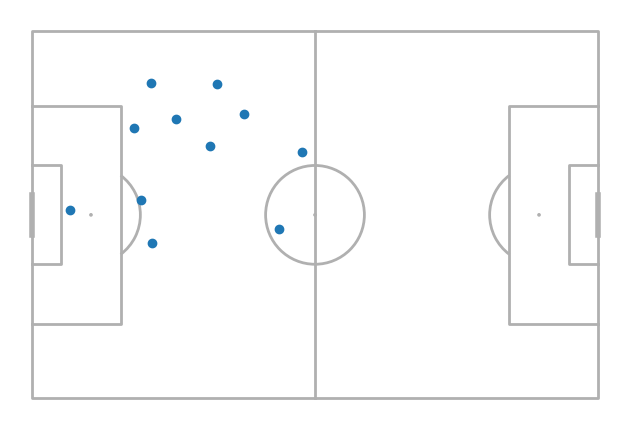

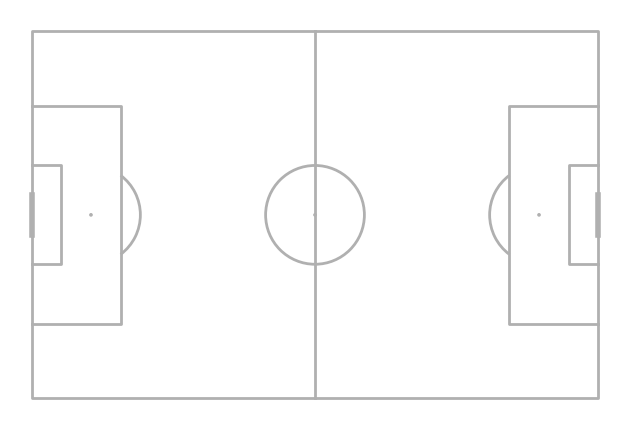

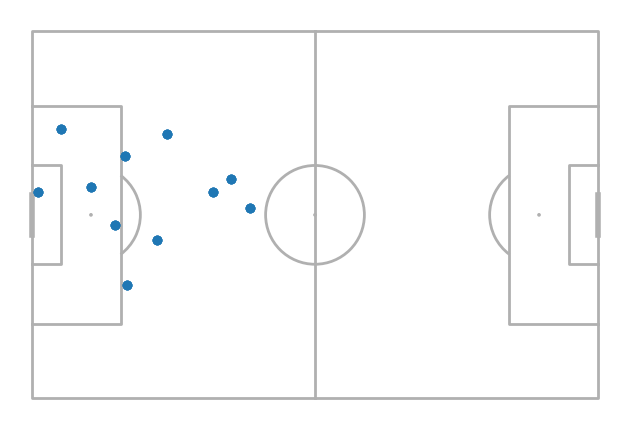

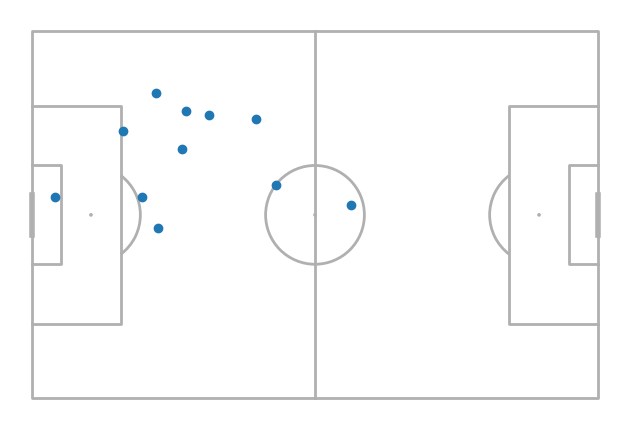

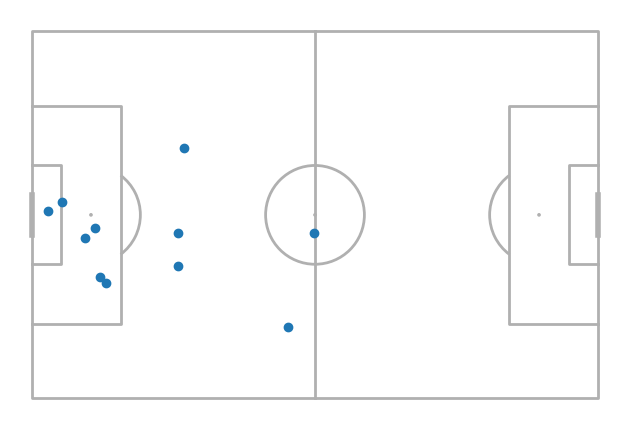

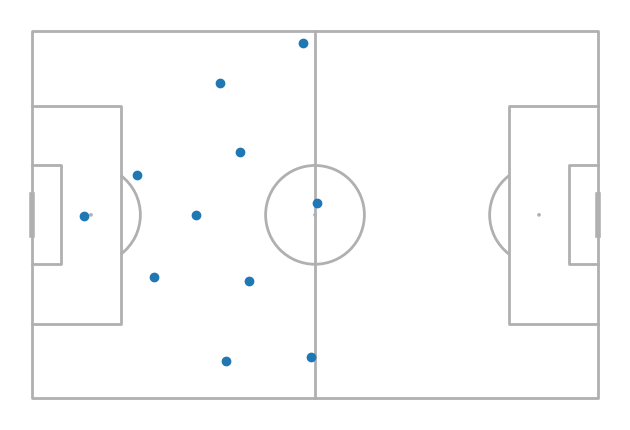

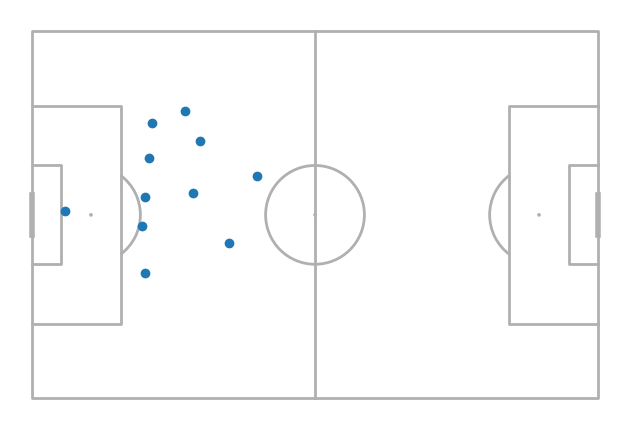

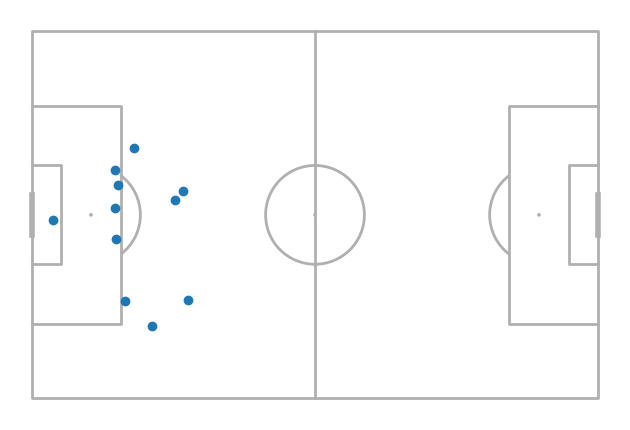

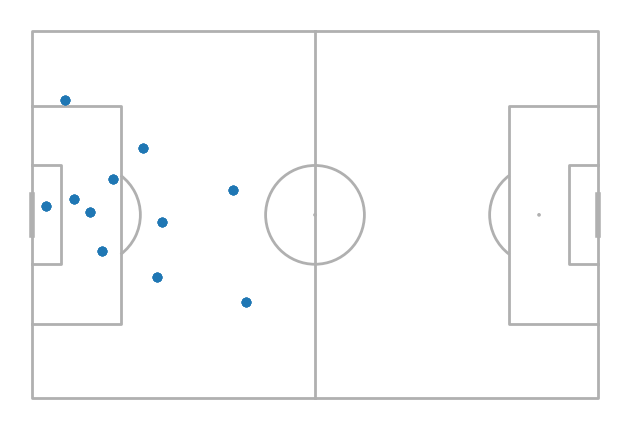

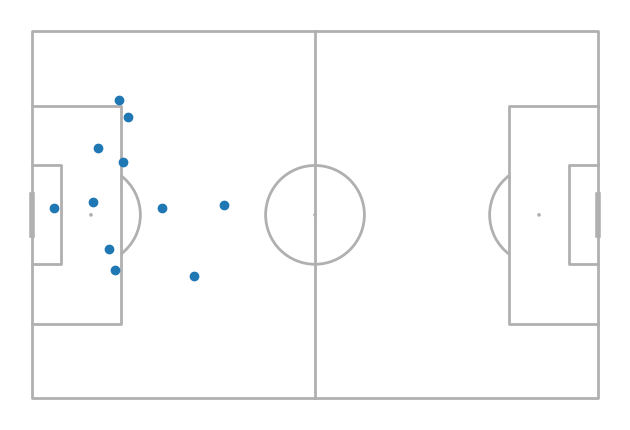

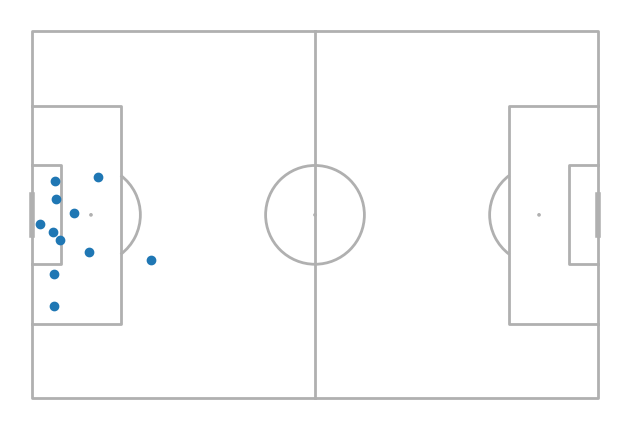

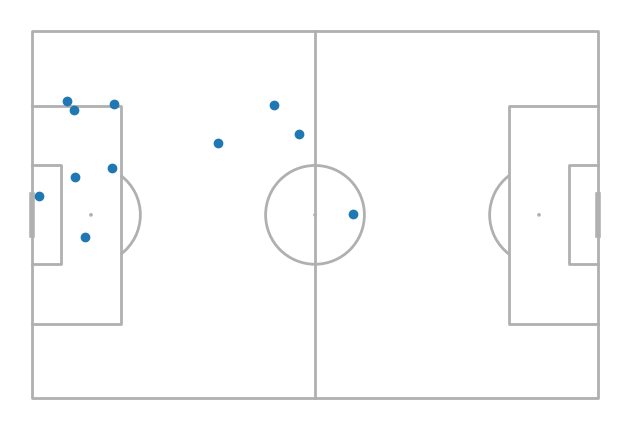

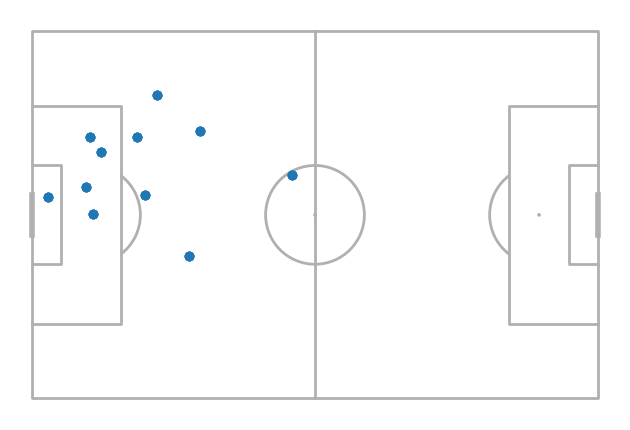

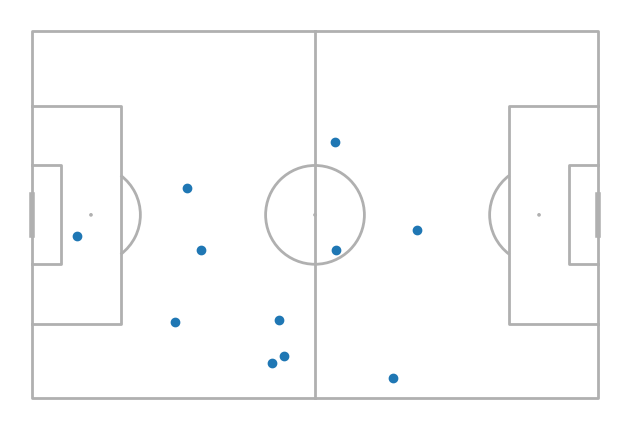

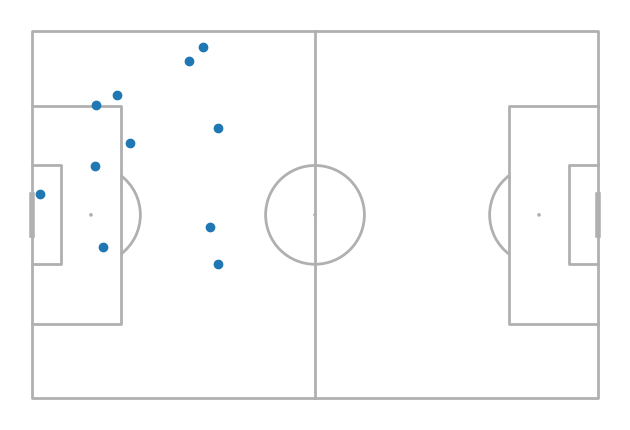

In [78]:
from mplsoccer import Pitch
pitch = Pitch(pitch_type = "skillcorner", pitch_length = 105, pitch_width = 68)
for i in range (15) :
    fig, ax = pitch.draw()
    pitch.scatter(tracking_data_adv[tracking_data_adv.centre_id == i][["x"]], tracking_data_adv[tracking_data_adv.centre_id == i][["y"]], ax = ax)